In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"   # disable GPU
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"    # silence most TF logs

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
csv_path = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_30_sec.csv"
df = pd.read_csv(csv_path)
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [3]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

label_col = "label"

drop_cols = [c for c in ["filename", "length"] if c in df.columns]

X = df.drop(columns=drop_cols + [label_col])
y = df[label_col]

le = LabelEncoder()
y_enc = le.fit_transform(y)
num_classes = len(le.classes_)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

X_train.shape, num_classes

((800, 57), 10)

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_model(input_dim, num_classes, lr=1e-3, n_layers=2, n_units=128, activation="relu"):
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))

    for _ in range(n_layers):
        model.add(layers.Dense(n_units, activation=activation))

    model.add(layers.Dense(num_classes, activation="softmax"))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_model(X_train.shape[1], num_classes)
history = model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)

2026-01-20 17:52:02.559015: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768931522.826337      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768931522.905195      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768931523.569575      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768931523.569667      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768931523.569672      55 computation_placer.cc:177] computation placer alr

In [5]:
from sklearn.metrics import accuracy_score, f1_score

probs = model.predict(X_test)
y_pred = np.argmax(probs, axis=1)

acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred, average="macro")  # macro for multi-class

acc, f1

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


(0.735, 0.7360202386771475)

In [6]:
configs = [
    {"lr": 1e-3,  "layers": 1, "units": 64,  "batch": 32,  "act": "relu"},
    {"lr": 1e-3,  "layers": 2, "units": 128, "batch": 32,  "act": "relu"},
    {"lr": 5e-4,  "layers": 2, "units": 128, "batch": 32,  "act": "relu"},
    {"lr": 1e-4,  "layers": 2, "units": 256, "batch": 32,  "act": "relu"},
    {"lr": 1e-3,  "layers": 3, "units": 128, "batch": 64,  "act": "relu"},
    {"lr": 1e-3,  "layers": 2, "units": 128, "batch": 64,  "act": "tanh"},
    {"lr": 5e-4,  "layers": 3, "units": 64,  "batch": 32,  "act": "tanh"},
    {"lr": 1e-3,  "layers": 2, "units": 256, "batch": 32,  "act": "relu"},
]

results = []

for cfg in configs:
    m = build_model(
        input_dim=X_train.shape[1],
        num_classes=num_classes,
        lr=cfg["lr"],
        n_layers=cfg["layers"],
        n_units=cfg["units"],
        activation=cfg["act"],
    )

    m.fit(X_train, y_train, epochs=30, batch_size=cfg["batch"], verbose=0)

    y_pred = np.argmax(m.predict(X_test), axis=1)
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average="macro")

    results.append({**cfg, "accuracy": acc, "f1_macro": f1})

import pandas as pd
results_df = pd.DataFrame(results).sort_values("f1_macro", ascending=False)
results_df

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


,lr,layers,units,batch,act,accuracy,f1_macro
1,0.0010,2,128,32,relu,0.755,0.754718
5,0.0010,2,128,64,tanh,0.750,0.748201
0,0.0010,1,64,32,relu,0.740,0.739399
2,0.0005,2,128,32,relu,0.735,0.736140
4,0.0010,3,128,64,relu,0.735,0.734649
7,0.0010,2,256,32,relu,0.725,0.727199
3,0.0001,2,256,32,relu,0.720,0.717086
6,0.0005,3,64,32,tanh,0.715,0.713490


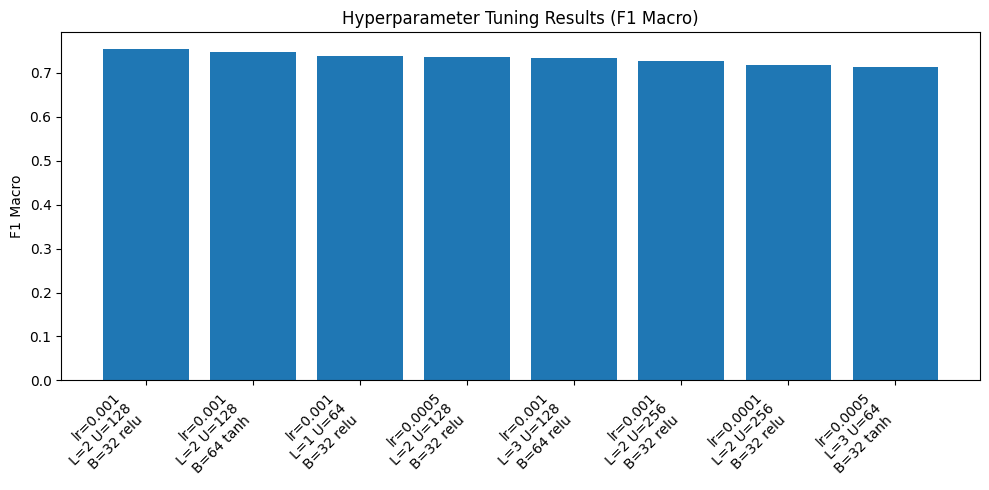

In [7]:
import matplotlib.pyplot as plt

plot_df = results_df.copy()
plot_df = plot_df.sort_values("f1_macro", ascending=False)

labels = [
    f"lr={r.lr}\nL={int(r.layers)} U={int(r.units)}\nB={int(r.batch)} {r.act}"
    for _, r in plot_df.iterrows()
]

plt.figure(figsize=(10,5))
plt.bar(range(len(plot_df)), plot_df["f1_macro"])
plt.xticks(range(len(plot_df)), labels, rotation=45, ha="right")
plt.ylabel("F1 Macro")
plt.title("Hyperparameter Tuning Results (F1 Macro)")
plt.tight_layout()
plt.show()

In [8]:
best = results_df.iloc[0]
best

lr             0.001
layers             2
units            128
batch             32
act             relu
accuracy       0.755
f1_macro    0.754718
Name: 1, dtype: object

In [9]:
best = results_df.iloc[0]

best_model = build_model(
    input_dim=X_train.shape[1],
    num_classes=num_classes,
    lr=best["lr"],
    n_layers=int(best["layers"]),
    n_units=int(best["units"]),
    activation=best["act"]
)

history = best_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=int(best["batch"]),
    validation_split=0.2,
    verbose=0
)

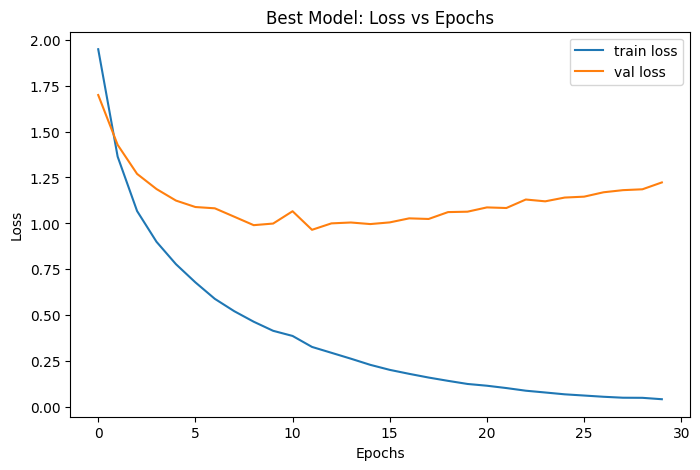

In [10]:
plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Best Model: Loss vs Epochs")
plt.legend()
plt.show()

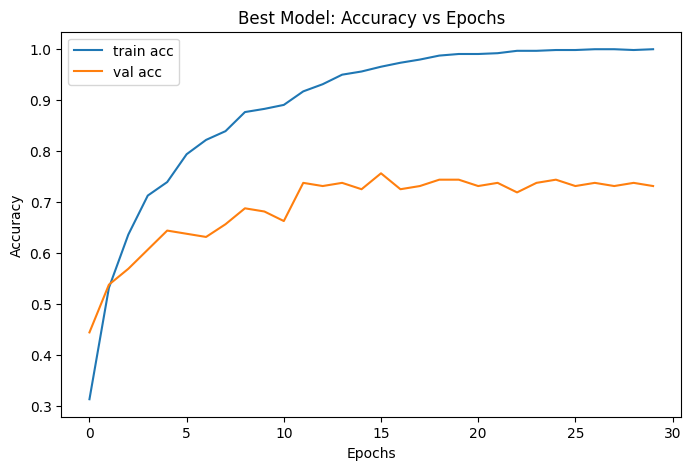

In [11]:
plt.figure(figsize=(8,5))
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Best Model: Accuracy vs Epochs")
plt.legend()
plt.show()